In [1]:
import sys
import os
directory = os.path.abspath(os.path.join('..'))
sys.path.append(directory)
import numpy as np
from matplotlib import pyplot as plt
from scripts.model_params import *
from scripts.cell_model import *
from scripts.batch_culture_simulation import *
import os
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.core.problem import ElementwiseProblem
from pymoo.optimize import minimize
from pymoo.core.problem import Problem
import numpy as np
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.termination import get_termination

Setting the multiobjective optimisation hyperparameters

In [ ]:
n_gens_single = 50
pop_size_single = 30

n_gens_multi = 80
pop_size_multi = 60

Defining the system topology parameters

In [2]:
#choosing the product transport method. 1 indicates this method is included
lin_trans      = 1
Tp_trans       = 0
T_trans        = 0
diff_trans     = 0

#mutaually exclusive; only one of these can be 1, rest must be 0
eprodtox       = 1
elongationtox  = 0

topology = [lin_trans, Tp_trans, T_trans, diff_trans, eprodtox, elongationtox]

Defining base parameters

In [3]:
# defining parameters
sS0 = 0.5; cultvol = 1.25 #quality of the nutrients and volume of the culture
vX = 726; kX = 1e3 # X export parameters
tmax = 20000; runintmax = 1e6 #simulation time parameters

N0  = 1e6
xS0 = 4.180555555555556e+22; # amount of glucose in media = 10g/L in 1.25L working vol in 3L vessel
M0 = 1e8 

creating the host and engineered parameter arrays

In [ ]:
base_params = [xS0, 0, runintmax, tmax, N0, topology]

hPR0, xPR0 = model_params(sS0, vX, kX, cultvol, leaky_control=False)
hPR = np.array(hPR0)
xPR = np.array(xPR0)
# 0     1       2       3       4         5        6        7           8
#[w0,   wT,     wE,     wEp,    wTF,    wpTox,    wTp,     k_Ep,    Km_Ep,     
#   9      10             11                 12
#  k_Tp,  Km_Tp, a_energy_pTox, a_elongation_pTox,
#   13      14      15       16       17   18    19
#  K_E,   K_pTox, kdiffP, VolCell, VolCult, ksf, ksr]

Setting specific circuit parameters

In [5]:
wT = 20; wE = 20; wEp = 20; wTF = 20; wpTox = 20;
K_E = 0.3; K_pTox = 1.0

xPR[[1, 2, 3, 4, 5, 13, 14]] = [wT, wE, wEp, wTF, wpTox, K_E, K_pTox]

param_indices = [1, 2, 3, 4, 5, 13, 14]             # e.g., wEp at index 2 (old behaviour)
# param_indices = [2, 3, 12]    # Example: optimize wEp, wTF, K_E
lower_bounds  = [0, 0, 0, 0, 0, 0, 0]             # lower bounds for each parameter
upper_bounds  = [200, 200, 200, 200, 200, 200, 200]           # upper bounds

n_params = len(param_indices)

Writing a wrapper to take wEp and return the productivity and yield

In [6]:
def calculate_prod_yield(x_vector):
    xPR_local = xPR.copy()
    for idx, value in zip(param_indices, x_vector):
        xPR_local[idx] = value

    _, __, vP, pY = batch_cult_sim(base_params, hPR, xPR_local)

    return -vP, -pY

Setting up the optimisation problems

In [7]:
class SingleObjective(ElementwiseProblem):
    def __init__(self, obj_id):
        super().__init__(n_var=n_params,
                         n_obj=1,
                         xl=lower_bounds,
                         xu=upper_bounds)
        self.obj_id = obj_id

    def _evaluate(self, x, out):
        obj_vec = calculate_prod_yield(x)
        out["F"] = obj_vec[self.obj_id]


class MultiObjectiveScaled(ElementwiseProblem):
    def __init__(self, scale):
        super().__init__(n_var=n_params,
                         n_obj=2,
                         xl=lower_bounds,
                         xu=upper_bounds)
        self.scale = scale

    def _evaluate(self, x, out):
        vP, pY = calculate_prod_yield(x)
        out["F"] = np.array([vP, pY]) / self.scale

Running the optimisation to find optimal vP

In [8]:
single_termination = get_termination("n_gen", 50)
res_vP = minimize(
    SingleObjective(obj_id=0),
    GA(pop_size=30),
    termination=single_termination,
    seed=1,
    verbose=True
)
max_vP = res_vP.F[0]
print("Max vP:", -max_vP)

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       30 | -3.437789E+19 | -6.960829E+19
     2 |       60 | -5.498126E+19 | -6.960829E+19
     3 |       90 | -6.490153E+19 | -6.964681E+19
     4 |      120 | -6.872169E+19 | -7.220901E+19
     5 |      150 | -7.071381E+19 | -7.818143E+19
     6 |      180 | -7.292889E+19 | -7.818143E+19
     7 |      210 | -7.589648E+19 | -8.079799E+19
     8 |      240 | -7.814776E+19 | -8.119810E+19
     9 |      270 | -7.922266E+19 | -8.134221E+19
    10 |      300 | -8.034949E+19 | -8.193011E+19
    11 |      330 | -8.125157E+19 | -8.261722E+19
    12 |      360 | -8.172037E+19 | -8.261722E+19
    13 |      390 | -8.231651E+19 | -8.390410E+19
    14 |      420 | -8.272431E+19 | -8.390410E+19
    15 |      450 | -8.316966E+19 | -8.445629E+19
    16 |      480 | -8.371753E+19 | -8.445629E+19
    17 |      510 | -8.424261E+19 | -8.520748E+19
    18 |      540 | -8.464340E+19 | -8.610913E+19
    19 |      570 | -8.511336E+19 | -8.621112E+19


Running the optimisation to find optimisal pY

In [9]:
res_pY = minimize(
    SingleObjective(obj_id=1),
    GA(pop_size=30),
    termination=single_termination,
    seed=1,
    verbose=True
)
max_pY = res_pY.F[0]
print("Max pY:", -max_pY)

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       30 | -4.393998E-01 | -9.671382E-01
     2 |       60 | -6.799032E-01 | -9.763817E-01
     3 |       90 | -9.157657E-01 | -9.965770E-01
     4 |      120 | -9.737957E-01 | -9.965809E-01
     5 |      150 | -9.833585E-01 | -9.965809E-01
     6 |      180 | -9.897366E-01 | -9.972783E-01
     7 |      210 | -9.963846E-01 | -9.972783E-01
     8 |      240 | -9.969959E-01 | -9.977664E-01
     9 |      270 | -9.973095E-01 | -9.977664E-01
    10 |      300 | -9.973265E-01 | -9.977664E-01
    11 |      330 | -9.974228E-01 | -9.978849E-01
    12 |      360 | -9.974968E-01 | -9.978849E-01
    13 |      390 | -9.975597E-01 | -9.978849E-01
    14 |      420 | -9.976385E-01 | -9.978849E-01
    15 |      450 | -9.977378E-01 | -9.978994E-01
    16 |      480 | -9.978262E-01 | -9.979035E-01
    17 |      510 | -9.978816E-01 | -9.980304E-01
    18 |      540 | -9.978965E-01 | -9.980304E-01
    19 |      570 | -9.979085E-01 | -9.980304E-01


Running the multiobjective optimisation

In [10]:
scale = np.array([abs(max_vP), abs(max_pY)])
termination = get_termination("n_gen", 80)
res = minimize(
    MultiObjectiveScaled(scale),
    NSGA2(pop_size=60),
    termination=termination,
    seed=1,
    verbose=True
)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       60 |      5 |             - |             -
     2 |      120 |     11 |  0.1309473489 |         ideal
     3 |      180 |     19 |  0.0087186336 |         ideal
     4 |      240 |     26 |  0.0503452686 |         ideal
     5 |      300 |     30 |  0.0030689691 |         nadir
     6 |      360 |     42 |  0.0044982153 |         nadir
     7 |      420 |     48 |  0.0474439338 |         ideal
     8 |      480 |     54 |  0.1400726622 |         nadir
     9 |      540 |     56 |  0.0155026046 |         ideal
    10 |      600 |     60 |  0.0072171070 |             f
    11 |      660 |     60 |  0.0048719076 |             f
    12 |      720 |     60 |  0.0054695773 |             f
    13 |      780 |     60 |  0.0051557650 |             f
    14 |      840 |     60 |  0.0053903734 |         ideal
    15 |      900 |     60 |  0.0050569027 |             f
    16 |      960 |     60 |  0.0048715126 |         ide

Extracting the pareto front

In [ ]:
pareto_X = res.X                          # parameter sets
pareto_scaled = res.F                     # scaled objectives
pareto_unscaled = pareto_scaled * scale   # real objectives

vP_vals = -pareto_unscaled[:, 0]
pY_vals = -pareto_unscaled[:, 1]

print("Pareto points:", len(vP_vals))

Pareto points: 60


C:\Users\amabe_mapds4e\AppData\Local\Temp\ipykernel_22488\1164556140.py:5: RuntimeWarning: overflow encountered in exp
  vP_vals = np.exp(-pareto_unscaled[:, 0])


Now plotting the pareto front

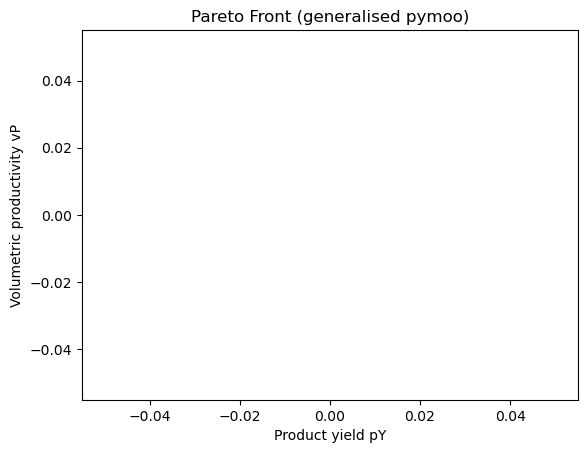

In [12]:
plt.scatter(pY_vals, vP_vals)
plt.xlabel("Product yield pY")
plt.ylabel("Volumetric productivity vP")
plt.title("Pareto Front (generalised pymoo)")
plt.show()